# 1. Contextualização
Robert é um Investidor Anjo e pretende fechar negócio com algumas startups dos Estados Unidos. Ele pretende fazer uma pesquisa entre 50 startups selecionadas e, para isso, irá precisar de uma análise estatística dessas empresas para tomar sua decisão.

Você foi contratado por Robert como Consultor de Ciência de Dados para realizar essa análise entre as 50 startups. Através de seus conhecimentos de estatística, faça o tratamento de dados necessário da base dessas empresas e monte um modelo de regressão que auxilie na tomada de decisão do investidor.

**Dataset**: https://www.kaggle.com/datasets/karthickveerakumar/startup-logistic-regression

# 2. Carregamento de bibliotecas e Funções

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy as pt
import scipy as sp
import seaborn as sns
import statsmodels.api as sm
from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
def desc_null(df):
    des = df.describe(include="all", datetime_is_numeric=True).T
    des["nullCount"] = df.shape[0] - des["count"]
    des["null%"] = (des["nullCount"] / df.shape[0]) * 100
    return des

In [3]:
def histplot(
    data, title=None, xlabel=None, ylabel=None, x=None, y=None, figsize=(10, 5), bins=10
):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=figsize)

    sns.histplot(data=data, x=x, y=y, bins=bins)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    return plt.show()

In [4]:
def corrplot(data):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 7))

    sns.heatmap(
        data=data.corr(),
        cmap=sns.diverging_palette(230, 20, as_cmap=True),
        vmin=-1,
        vmax=1,
        annot=True,
    )

    return plt.show()

In [5]:
def feat_scale(x):
    import numpy as np

    # Calcular a média da variável
    mean = np.mean(x, axis=0)

    # Calcular o desvio padrão amostral da variável
    sigma = np.std(x, axis=0, ddof=1)

    # Realizar o escalonamento
    xnorm = (x - mean) / sigma

    return xnorm

# 3. Carregamento dos dados

* **R&D Spend**: Gastos com pesquisa e desenvolvimento pela startup (USD)
    * Range: 0,00 - 165.349,20
* **Administration**: Gastos administrativos pela startup (USD)
    * Range: 51.283,14 - 182.645,56
* **Marketing Spend**: Gastos com marketing pela startup (USD)
    * Range: 0,00 - 471.784,10
* **State**: Estado de origem da startup
    * 3 valores únicos: New York (17), California (17), Florida (16)
* **Profit**: Lucros da statup
    * Range: 14.681,40 - 192.261,83

In [6]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/bruna-calistrate/"
    "AdvancedStatistics-Course/main/data/50_Startups.csv"
)

In [7]:
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [9]:
desc_null(df)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max,nullCount,null%
R&D Spend,50.0,NaN,NaN,NaN,73721.6156,45902.256482,0.0,39936.37,73051.08,101602.8,165349.2,0.0,0.0
Administration,50.0,NaN,NaN,NaN,121344.6396,28017.802755,51283.14,103730.875,122699.795,144842.18,182645.56,0.0,0.0
Marketing Spend,50.0,NaN,NaN,NaN,211025.0978,122290.310726,0.0,129300.1325,212716.24,299469.085,471784.1,0.0,0.0
State,50,3,New York,17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0
Profit,50.0,NaN,NaN,NaN,112012.6392,40306.180338,14681.4,90138.9025,107978.19,139765.9775,192261.83,0.0,0.0


In [10]:
df["State"].value_counts()

New York      17
California    17
Florida       16
Name: State, dtype: int64

# 4. Análise Exploratória dos dados

Traga os dados estatísticos descritivos apresentados na base para cada propriedade.

* Plote histogramas para analisar a distribuição em cada uma das propriedades. 
    * Plote gráficos de barras que demonstrem a distribuição dos estados. 
    * Plote também, gráficos de correlação para cada uma das propriedades.
* Crie um gráfico box-plot que traga o lucro das startups por estado.

## 4.1. Distribuição 

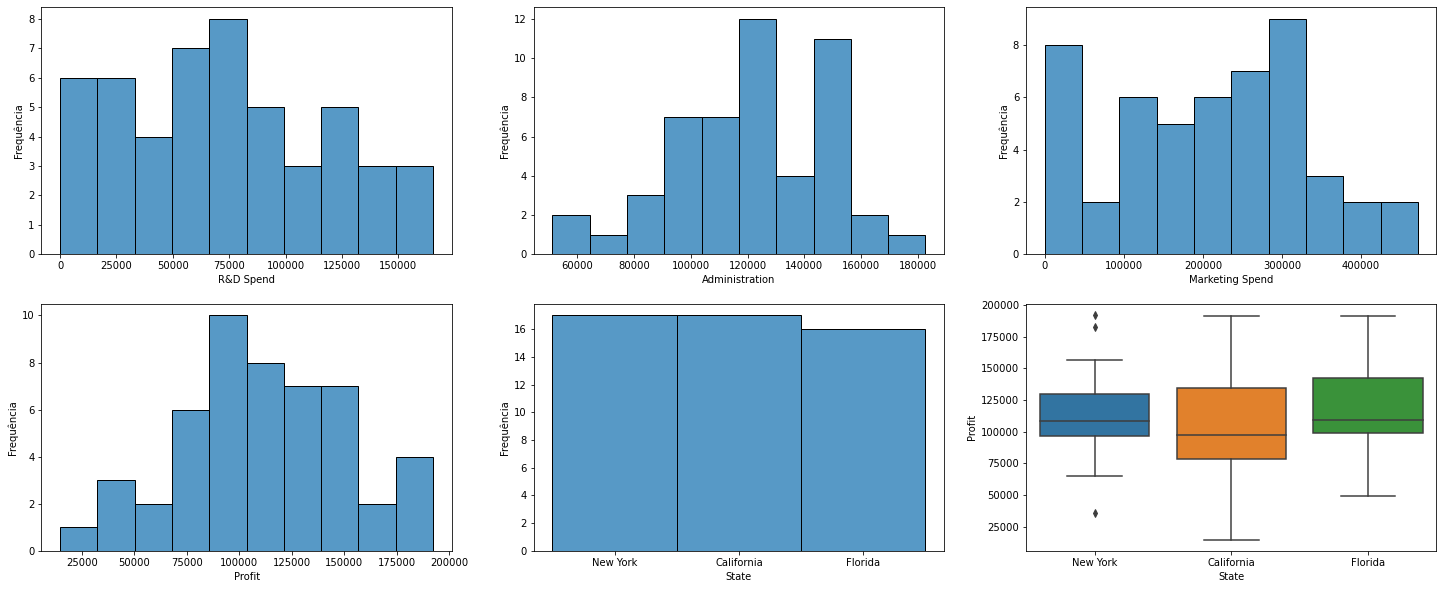

In [11]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

c = 0
for i in range(2):
    for j in range(3):
        if i == 1 and j == 2:
            sns.boxplot(data=df, y="Profit", x="State", ax=axes[i, j])
        else:
            sns.histplot(
                data=df,
                x=["R&D Spend", "Administration", "Marketing Spend", "Profit", "State"][
                    c
                ],
                ax=axes[i, j],
                bins=10,
            ).set_ylabel("Frequência")
            c += 1

plt.show()

## 4.2. Correlação

Existe uma correlação positiva muito alta entre:
* **R&D Spend** e **Profit** de 0,97
* **Marketing Spend** e **Profit** de 0,75

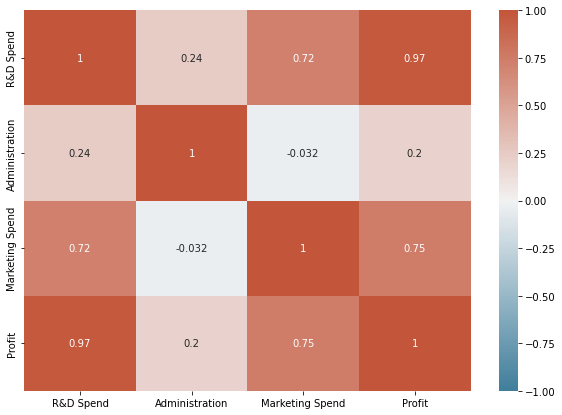

In [12]:
corrplot(df)

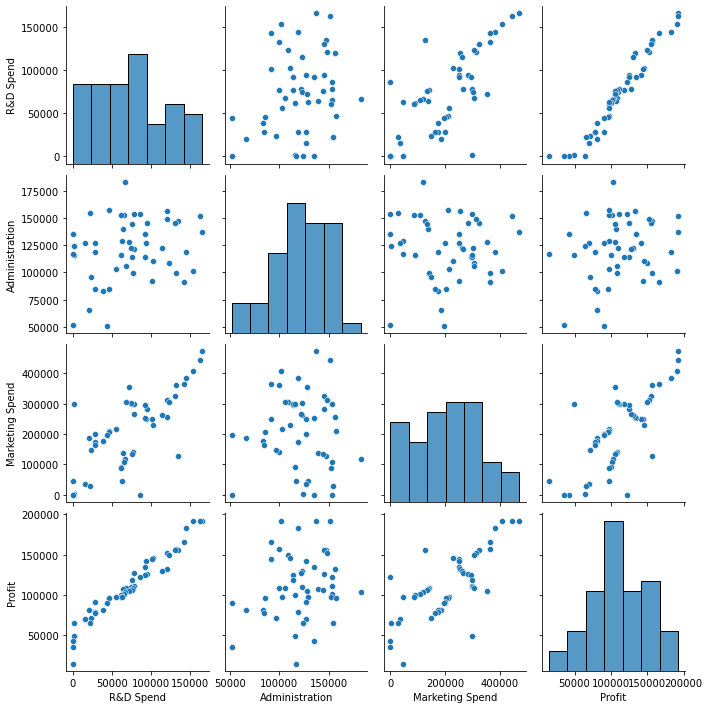

In [13]:
sns.pairplot(df)

# 5. Pré-Processamento de Dados

* Separar as variáveis em contínuas, categóricas e resposta;
* Realize o pré-tratamento das variáveis;
* Aplique o escalonamento das variáveis contínuas, dummyficação das variáveis categóricas e avalia se a resposta precisa de tratamento

## 5.1. Separação das variáveis

In [14]:
resp = df["Profit"]
num = list(df.select_dtypes(include=[np.number]).drop(columns="Profit"))
cat = list(df.select_dtypes(exclude=[np.number]))

## 5.2. Transformação da resposta - **Profit**

Ela precisa chegar o mais próximo de uma distribuição normal para ser utilizada no modelo

### 5.2.1. Teste de normalidade

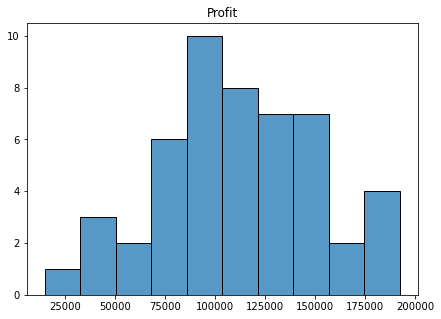

In [15]:
histplot(data=resp, figsize=(7, 5), title="Profit")

In [16]:
kStat, kPvalue = sp.stats.kstest(resp, cdf="norm")

print(f"Stat: {kStat} - P Value: {kPvalue}")

Stat: 1.0 - P Value: 0.0


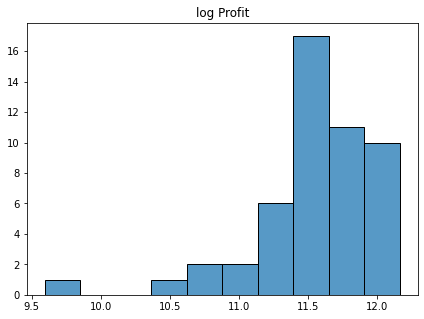

In [17]:
histplot(data=np.log(resp), figsize=(7, 5), title="log Profit")

In [18]:
kStat, kPvalue = sp.stats.kstest(np.log(resp), cdf="norm")

print(f"Stat: {kStat} - P Value: {kPvalue}")

Stat: 1.0 - P Value: 0.0


Como não foi possível normalizar mais a resposta, seguir com a distribuição atual.

## 5.3. Escalonamento das variáveis contínuas

In [19]:
for n in num:
    nStats, nPvalue = sp.stats.kstest(df[n], cdf="norm")
    print(f"{n} - stats = {nStats:.3f}, p = {nPvalue:.3f}")

R&D Spend - stats = 0.960, p = 0.000
Administration - stats = 1.000, p = 0.000
Marketing Spend - stats = 0.940, p = 0.000


In [20]:
dfNum = feat_scale(df[num])

In [21]:
for n in num:
    nStats, nPvalue = sp.stats.kstest(dfNum[n], cdf="norm")
    print(f"{n} - stats = {nStats:.3f}, p = {nPvalue:.3f}")

R&D Spend - stats = 0.080, p = 0.885
Administration - stats = 0.077, p = 0.904
Marketing Spend - stats = 0.084, p = 0.841


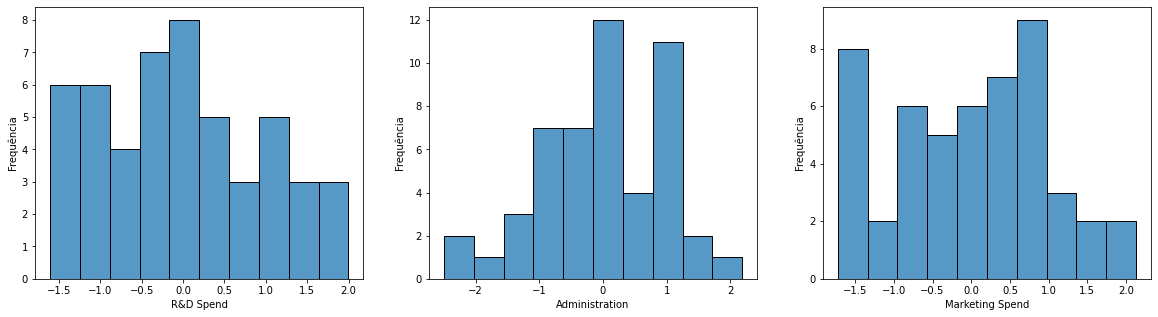

In [22]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 5))

for j, n in zip(range(3), num):
    sns.histplot(data=dfNum, x=n, ax=axes[j], bins=10).set_ylabel("Frequência")

plt.show()

## 5.4. One-Hot Encoding das variáveis categóricas

In [43]:
dfCat = pd.get_dummies(df[cat], columns=cat)
dfCat.head()

,State_California,State_Florida,State_New York
0,0,0,1
1,1,0,0
2,0,1,0
3,0,0,1
4,0,1,0


## 5.5. Unificação dos dataframes criados no pré-tratamento

In [44]:
dfFinal = pd.concat([dfNum, dfCat, resp], axis=1)

dfFinal.head()

,R&D Spend,Administration,Marketing Spend,State_California,State_Florida,State_New York,Profit
0,1.996146,0.555117,2.132295,0,0,1,192261.83
1,1.936203,1.071924,1.904267,1,0,0,191792.06
2,1.736731,-0.720938,1.610180,0,1,0,191050.39
3,1.539157,-0.095396,1.407916,0,0,1,182901.99
4,1.489812,-1.069066,1.268648,0,1,0,166187.94


# 6. Ajuste do modelo de regressão


In [45]:
dfFinal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   R&D Spend         50 non-null     float64
 1   Administration    50 non-null     float64
 2   Marketing Spend   50 non-null     float64
 3   State_California  50 non-null     uint8  
 4   State_Florida     50 non-null     uint8  
 5   State_New York    50 non-null     uint8  
 6   Profit            50 non-null     float64
dtypes: float64(4), uint8(3)
memory usage: 1.8 KB


## 6.1. Renomear as colunas

Ajuste para desenvolver o modelo, não podem haver espaços

In [46]:
dfFull = dfFinal.copy()

dfFull.rename(
    columns={
        "R&D Spend": "rd_spend",
        "Administration": "admin_spend",
        "Marketing Spend": "mkt_spend",
        "State_Florida": "fl",
        "State_New York": "ny",
        "State_California": "ca",
    },
    inplace=True,
)

dfFull.head()

,rd_spend,admin_spend,mkt_spend,ca,fl,ny,Profit
0,1.996146,0.555117,2.132295,0,0,1,192261.83
1,1.936203,1.071924,1.904267,1,0,0,191792.06
2,1.736731,-0.720938,1.610180,0,1,0,191050.39
3,1.539157,-0.095396,1.407916,0,0,1,182901.99
4,1.489812,-1.069066,1.268648,0,1,0,166187.94


## 6.2. Método mínimos quadrados (ordinary least squares)

### 6.2.1. Função para escrever a fórmula

In [27]:
def ols_formula(df, dependent_var, *excluded_rows):

    # Listar o nome das colunas do dataframe
    cols = list(df.columns)

    # Remover a variável dependente
    cols.remove(dependent_var)

    # Remover as variáveis excluídas
    for col in excluded_rows:
        cols.remove(col)

    # Retornar a fórmula
    return dependent_var + " ~ " + " + ".join(cols)

### 6.2.2. Matriz do modelo

In [47]:
y, x = pt.dmatrices(ols_formula(dfFull, "Profit"), data=dfFull, return_type="dataframe")

### 6.2.3. Ajuste da matriz

In [48]:
reg = sm.OLS(y, x)

regfit = reg.fit()

In [49]:
regfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 05 May 2022   Prob (F-statistic):           1.34e-27
Time:                        09:53:53   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.401e+04   1001.609     83.877      0.000     8.2e+04     8.6e+04
rd_spend       3.7e+04   2130.184     17.369      0.000    3.27e+04    4.13e+04
admin_spend  -756.6017   1463.413     -0.517      0.608   -3705.917    2192.714
mkt_spend    3299.3756   2096.320      1.574      0.123    -925.479    7524.231
ca           2.795e+04   1932.496     14.464      0.000    2.41e+04    3.18e+04
fl           2.815e+04   1993.572     14.121      0.000    2.41e+04    3.22e+04
ny           2.791e+04   1913.989     14.582      0.000    2.41e+04    3.18e+04
==============================================================================
Omnibus:                       14.782   Durbin-Watson:                   1.283
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               21.266
Skew:                          -0.948   Prob(JB):                     2.41e-05
Kurtosis:                       5.572   Cond. No.                     1.96e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.26e-31. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## 6.3. Método Gradiente Descendente
Apresenta framework de trabalho mais genérico, entender a relação entre as respostas e os preditores


### 6.3.1. Função perda
* Previsão da resposta
* Calcular os erros de previsão
* Calcular o quadrado dos erros
* Calcular a perda

In [31]:
def funcao_perda(x, y, beta):
    import numpy as np

    """
    x é a matriz com os regressores 
    y é a série com a resposta
    beta é a série dos parâmetros
    """
    m, n = x.shape

    # Previsão da resposta: produto escalar entre os vetores de parâmetros e o dataframe com os regressores
    pred = x.dot(beta)

    # Calcular os erros de previsão: é a diferença entre o valor real da variável y e o valor previsto pelo modelo
    res = np.subtract(pred, y.squeeze())

    # Calcular o quadrado dos erros
    sqrRes = np.square(res)

    # Calcular a perda
    perda = 1 / (2 * m) * np.sum(sqrRes)

    return perda

### 6.3.2. Função gradiente descendente

In [32]:
def grad_des(x, y, beta, alpha, itera):
    import numpy as np

    """
    x é a matriz dos regressores
    y é a série da resposta
    beta é a série dos valores iniciais dos parâmetros
    alpha é a taxa de aprendizagem (escalar), determina o quanto o algoritmo vai caminhar em direção ao novo beta
    itera é o número de iterações do algoritmo
    
    Resultados
    
    beta é a série com os valores finais dos parâmetros
    hperda é a série histórica das perdas
    """
    m, n = x.shape

    # Inicializa a série do histórico de perdas: ajuda a encontrar os melhores valores de alpha para alcançar uma melhor convergência
    hPerda = np.zeros(itera)

    for i in range(itera):

        # Calcula as previsões com os valores atuais dos parâmetros
        pred = x.dot(beta)

        # Calcula os resíduos de previsão: previsão - resposta
        res = np.subtract(pred, y.squeeze())

        # Calcula o incremento/decremento valor dos betas - derivada parcial da função perda:
        # quanto maior o alpha, maior o passo que o algoritmo dará para o próximo beta
        sumDelta = (alpha / m) * x.transpose().dot(res)

        # Atualizar os valores dos betas do modelo
        beta = beta - sumDelta

        # Calcula a nova perda com os novos valores dos betas
        hPerda[i] = funcao_perda(x, y, beta)

    return beta, hPerda

### 6.3.3. Aplicação do algoritmo
* Configure o algoritmo
* Aplique o algoritmo
* Estude a convergência

Lembrando que o df x não contempla a feature resposta '**Profit**'

In [50]:
# Salva o tamanho do df x com os regressores - incluindo intercept
m, n = x.shape

# Inicializa a série de betas
beta = np.zeros(n)

# Quantidade de iterações
itera = 1000

# Taxa de aprendizagem, quanto maior o valor, mais rápida é a taxa
alpha = 0.3

In [51]:
x.head()

,Intercept,rd_spend,admin_spend,mkt_spend,ca,fl,ny
0,1.0,1.996146,0.555117,2.132295,0.0,0.0,1.0
1,1.0,1.936203,1.071924,1.904267,1.0,0.0,0.0
2,1.0,1.736731,-0.720938,1.610180,0.0,1.0,0.0
3,1.0,1.539157,-0.095396,1.407916,0.0,0.0,1.0
4,1.0,1.489812,-1.069066,1.268648,0.0,1.0,0.0


In [52]:
beta

array([0., 0., 0., 0., 0., 0., 0.])

In [53]:
beta, hPerda = grad_des(x=x, y=y, beta=beta, alpha=alpha, itera=itera)

In [54]:
beta

Intercept      84011.676723
rd_spend       36998.279697
admin_spend     -756.601699
mkt_spend       3299.375589
ca             27951.591650
fl             28150.380443
ny             27909.704631
dtype: float64

### 6.3.4. Estudo de convergência

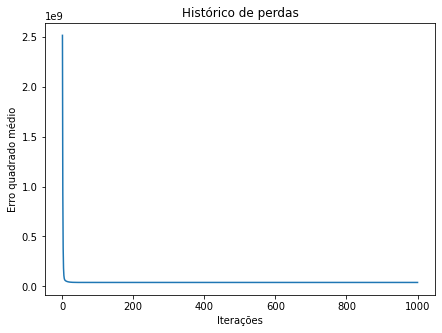

In [55]:
plt.figure(figsize=(7, 5))

sns.lineplot(x=range(1, itera + 1), y=hPerda)

plt.xlabel("Iterações")
plt.ylabel("Erro quadrado médio")
plt.title("Histórico de perdas")

plt.show()

# 7. Significância estatística
* Crie um sumário e analise os dados de significância estatística do modelo;
* Reajuste do modelo e criação de matriz
* Reajuste o sumário e traga as informações fundamentasi a serem analisadas

## 7.1. Sumário do modelo

In [56]:
print(regfit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.951
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     169.9
Date:                Thu, 05 May 2022   Prob (F-statistic):           1.34e-27
Time:                        09:54:20   Log-Likelihood:                -525.38
No. Observations:                  50   AIC:                             1063.
Df Residuals:                      44   BIC:                             1074.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    8.401e+04   1001.609     83.877      

## 7.2. Reajuste do modelo

Retirando a variável **adm** por ser pouco representativa

### 7.2.1. Nova matriz do modelo

In [60]:
y, xRed = pt.dmatrices(
    ols_formula(dfFull, "Profit", "admin_spend"), data=dfFull, return_type="dataframe"
)

### 7.2.2. Ajuste da matriz
Ao remover um fator não significativo do modelo, para ajuste melhor.

In [62]:
reg2 = sm.OLS(y, xRed)
reg2fit = reg2.fit()

In [64]:
print(reg2fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 Profit   R-squared:                       0.950
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     215.8
Date:                Thu, 05 May 2022   Prob (F-statistic):           9.72e-29
Time:                        10:13:11   Log-Likelihood:                -525.53
No. Observations:                  50   AIC:                             1061.
Df Residuals:                      45   BIC:                             1071.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   8.401e+04    993.420     84.567      0.0